### Seq2Seq Model - Handwritten Prediction

In [1]:
import pandas as pd
import numpy as np
import random
import pandas as pd
from PIL import Image
import os
import random

import torch
from torch.utils.data import Dataset
from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from transformers import TrOCRProcessor
from transformers import VisionEncoderDecoderModel
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_metric
from transformers import default_data_collator

#### Cleaning data

In [3]:
path_to_csv = 'csvs/before_cleaned_data.csv'
df = pd.read_csv(path_to_csv, low_memory=False)
df = df.drop(columns= 'Unnamed: 0')
df

,campo,x,y,w,h,text,jpg_file_name
0,fecha,42,106,124,21,4/1/2018,parte_amistoso_9_9_9.jpg
1,fecha,42,106,156,21,2/7/2012,parte_amistoso_0_23_3.jpg
2,fecha,42,109,101,18,14/1/1980,parte_amistoso_1_19_3.jpg
3,fecha,42,109,101,18,14/1/1980,parte_amistoso_1_20_3.jpg
4,fecha,42,109,101,18,14/1/1980,parte_amistoso_1_23_3.jpg
...,...,...,...,...,...,...,...
253872,B 4,734,425,17,18,X,parte_amistoso_9_9_9.jpg
253873,B 3,731,393,15,14,X,parte_amistoso_9_9_9.jpg
253874,B 2,730,359,0,0,,parte_amistoso_9_9_9.jpg
253875,B 1,733,330,16,12,X,parte_amistoso_9_9_9.jpg


In [4]:
path_to_csv = r'csvs/classes.csv'
classes = pd.read_csv(path_to_csv, low_memory=False)
classes

,Unnamed: 0,classes,encoding
0,0,A aseguradora agencia,0
1,1,A aseguradora agencia direccion,1
2,2,A aseguradora agencia nombre,2
3,3,A aseguradora carta_verde,3
4,4,A aseguradora carta_verde_desde,4
...,...,...,...
108,108,localizacion pais,108
109,109,lugar,109
110,110,testigos,110
111,111,victimas no,111


In [5]:
# Deleting classes that are not needed
delete = ['A 1','A 10','A 11','A 12','A 13','A 14','A 15','A 16',
          'A 17','A 2','A 3','A 4','A 5','A 6','A 7','A 8','A 9', 
          'A n_casillas','B 1','B 10','B 11','B 12','B 13','B 14',
          'B 15','B 16','B 17','B 2','B 3','B 4','B 5','B 6','B 7',
          'B 8','B 9', 'B n_casillas', 'A  aseguradora danos_propios_no',
          'A  aseguradora danos_propios_si', 'B aseguradora danos_propios no',
          'B aseguradora danos_propios si', 'victimas no', 'victimas si', 'danos_materiales objetos no',
        'danos_materiales objetos si', 'danos_materiales vehiculos si','danos_materiales vehículos no']

In [6]:
def remove_rows_with_value(df, column_name, value):
    new_df = df[df[column_name] != value]
    return new_df

new_df = df
new_classese = classes
for c in delete:
    new_df = remove_rows_with_value(new_df, 'campo', c)
    new_classese = remove_rows_with_value(new_classese, 'classes', c)

print(new_df)
print(new_classese)

                           campo    x     y    w   h            text  \
0                          fecha   42   106  124  21        4/1/2018   
1                          fecha   42   106  156  21        2/7/2012   
2                          fecha   42   109  101  18       14/1/1980   
3                          fecha   42   109  101  18       14/1/1980   
4                          fecha   42   109  101  18       14/1/1980   
...                          ...  ...   ...  ...  ..             ...   
253832      B conductor telefono  872  1070  246  23      6552934466   
253833       B conductor permiso  935  1100  132  15       14796729W   
253834     B conductor categoria  919  1122   40  19              A2   
253835  B conductor valido_hasta  911  1148  134  17       14/1/2035   
253836        B danos_apreciados  982  1431  187  15  ALETA AVERIADO   

                    jpg_file_name  
0        parte_amistoso_9_9_9.jpg  
1       parte_amistoso_0_23_3.jpg  
2       parte_amistoso_1_19

In [ ]:
# Passing the new_classes db to csv
# new_classese.to_csv(r'C:\Users\ismae\Desktop\3rd-year-uni\Statistical-Learning\final_project\new_classes.csv')

#### Encoding of data


In [7]:
le = LabelEncoder()

# fit and transform the 'campo' column
new_df['campo'] = le.fit_transform(new_df['campo'])

# print the encoding used for each label
classes = list(le.classes_)
encoding = list(le.transform(le.classes_))
print(classes)
print(encoding)

['A  aseguradora agencia', 'A  aseguradora agencia direccion', 'A  aseguradora agencia nombre', 'A  aseguradora carta_verde', 'A  aseguradora carta_verde_desde', 'A  aseguradora carta_verde_hasta', 'A  aseguradora num_poliza', 'A  aseguradora pais', 'A  aseguradora telefono', 'A  aseguradora_nombre', 'A  conductor apellidos', 'A  conductor categoria', 'A  conductor danos_apreciados', 'A  conductor direccion', 'A  conductor fecha_nac', 'A  conductor nombre', 'A  conductor pais', 'A  conductor permiso', 'A  conductor telefono', 'A  conductor valido_hasta', 'A  remolque matricula', 'A  remolque pais', 'A  vehiculo marca_modelo', 'A  vehiculo matricula', 'A  vehiculo pais', 'A asegurado apellidos', 'A asegurado codigo_postal', 'A asegurado direccion', 'A asegurado nombre', 'A asegurado pais', 'A asegurado telefono', 'B asegurado apellidos', 'B asegurado codigo_postal', 'B asegurado direccion', 'B asegurado nombre', 'B asegurado pais', 'B asegurado telefono', 'B aseguradora agencia', 'B ase

#### Generating instances of cropped images from all dataset
In total it will be aproximately 16k images for training

In [8]:
def generate_cropped_images(df):
    unique_campos = df['campo'].unique()
    os.makedirs('text_images', exist_ok=True)

    # Selects sample of 300 images for each campo
    for campo in unique_campos:
        campo_df = df[df['campo'] == campo]
        selected_samples = campo_df.sample(min(500, len(campo_df)), replace=False)

        for _, row in selected_samples.iterrows():
            image_path = row["jpg_file_name"]
            img = Image.open('data/' + image_path)
            cropped_image = img.crop((int(row["x"]), int(row["y"]), int(row["x"]) + int(row["w"]), int(row["y"]) + int(row["h"])))
            cropped_image_path = os.path.join('text_images', f'{os.path.splitext(image_path)[0]}_{campo}.jpg')
            try:
                cropped_image.save(cropped_image_path)
            except Exception:
                pass

In [9]:
# Generate cropped images for training
# generate_cropped_images(new_df)

In [10]:
# Function to create dataset of format image_name: ..., text: ...
def create_cropped_images_df():
    def get_text(file, orig_file, campo):
        text = new_df.loc[(new_df['jpg_file_name'] == str(orig_file)) & (new_df['campo'] == int(campo)), 'text'].iloc[0]
        return text
    files = os.listdir('text_images')
    campos = [file.split('_')[-1].split('.')[0] for file in files]
    orig_files = [file.replace(f'_{campo}.jpg', '.jpg') for file, campo in zip(files, campos)]
    cropped_images = [file for file in files]
    texts = [get_text(file, orig_file, campo) for file, orig_file, campo in zip(files, orig_files, campos)]

    return pd.DataFrame({'cropped_images': cropped_images, 'text': texts})

In [11]:
# Create dataframe out of cropped images
# cropped_images_df = create_cropped_images_df()
# cropped_images_df

In [12]:
# cropped_images_df.to_csv(r'C:\Users\ismae\Desktop\3rd-year-uni\Statistical-Learning\final_project\image2text.csv')

In [14]:
cropped_images_df = pd.read_csv('csvs/image2text.csv')

In [15]:
train_df, test_df = train_test_split(cropped_images_df, test_size=0.5)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [16]:
# Create class for image processing, labeling and formatting for torch tensor
class ImageDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['cropped_images'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [20]:
# Loading all processors
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten")
train_dataset = ImageDataset(root_dir='insurance-automation/docs/text_images/',
                           df=train_df,
                           processor=processor)
eval_dataset = ImageDataset(root_dir='insurance-automation/docs/text_images/',
                           df=test_df,
                           processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [21]:
# Checking sizes of datasets
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 16739
Number of validation examples: 16739


In [22]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


In [23]:
# Sample image from dataset
image = Image.open(train_dataset.root_dir + train_df['cropped_images'][0]).convert("RGB")
image

In [24]:
# Finding label and decoding it
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

11949


#### Training 

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [25]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-stage1")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Importantly, we need to set a couple of attributes, namely:

the attributes required for creating the decoder_input_ids from the labels (the model will automatically create the decoder_input_ids by shifting the labels one position to the right and prepending the decoder_start_token_id, as well as replacing ids which are -100 by the pad_token_id)
the vocabulary size of the model (for the language modeling head on top of the decoder)
beam-search related parameters which are used when generating text.

In [26]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [27]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    output_dir="./",
    fp16=True,
    gradient_accumulation_steps=2,
    logging_steps=2,
    save_steps=1000,
    eval_steps=1000,
)

In [28]:
cer_metric = load_metric("cer")

C:\Users\ismae\AppData\Local\Temp\ipykernel_22260\4287149634.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


The compute_metrics function takes an EvalPrediction (which is a NamedTuple) as input, and should return a dictionary. The model will return an EvalPrediction at evaluation, which consists of 2 things:

- predictions: the predictions by the model.
- label_ids: the actual ground-truth labels.

In [29]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [30]:
# Check th status of cuda for memory optimization
torch.cuda.empty_cache()
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [31]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
# trainer.train('checkpoint-10000')

C:\Users\ismae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\transformers\models\trocr\processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
Using cuda_amp half precision backend


In [32]:
# saving model weights
# trainer.save_model(r'C:\Users\ismae\Desktop\3rd-year-uni\Statistical-Learning\final_project\tuned-trocr')

#### Evaluation


In [33]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten")

loading configuration file preprocessor_config.json from cache at C:\Users\ismae/.cache\huggingface\hub\models--microsoft--trocr-small-handwritten\snapshots\55eb2010aeaaa246defc329d42939e0253d55c99\preprocessor_config.json
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
size should be a dictionary on of the following set of keys: ({'height', 'width'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}), got 384. Converted to {'height': 384, 'width': 384}.
crop_size should be a dictionary on of the following set of keys: ({'height', 'width'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
Image processor DeiTImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
  

In [35]:
model = VisionEncoderDecoderModel.from_pretrained("tuned-seq2seqv1")

loading configuration file tuned-seq2seqv1\config.json
Model config VisionEncoderDecoderConfig {
  "_commit_hash": null,
  "_name_or_path": "microsoft/trocr-small-stage1",
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "",
    "activation_dropout": 0.0,
    "activation_function": "relu",
    "add_cross_attention": true,
    "architectures": null,
    "attention_dropout": 0.0,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 0,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": 0.0,
    "cross_attention_hidden_size": 384,
    "d_model": 256,
    "decoder_attention_heads": 8,
    "decoder_ffn_dim": 1024,
    "decoder_layerdrop": 0.0,
    "decoder_layers": 6,
    "decoder_start_token_id": 2,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "dropout": 0.1,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 2,
    "exponential_decay_length_penalty": null,
  

In [36]:
files = []

def retrieve_sample():
    sample = random.randint(1, 15000)
    image = Image.open(eval_dataset.root_dir + train_df['cropped_images'][sample]).convert("RGB")
    # calling the processor is equivalent to calling the feature extractor
    pixel_values = processor(image, return_tensors="pt").pixel_values
    return image, pixel_values

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

C:\Users\ismae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\transformers\generation\utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 64 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


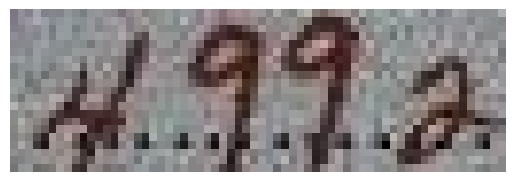

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



4992


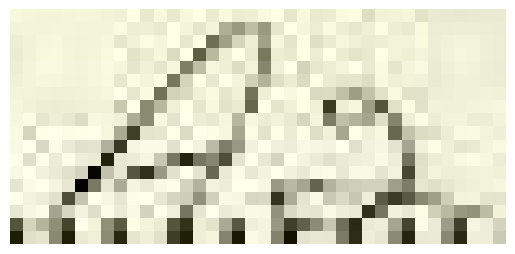

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



A2


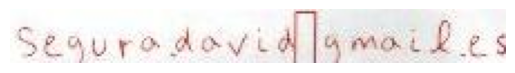

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



Segura.david@gmail.es


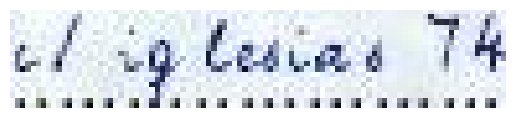

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



c/ iglesias 74


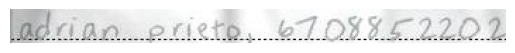

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



adrian prieto, 6708852202


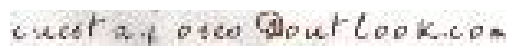

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



cuesta.josep@outlook.com


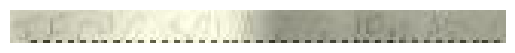

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



DESCONDIDO DE LADO


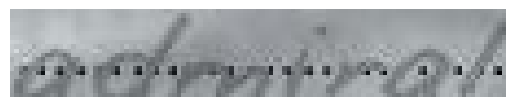

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



admiral


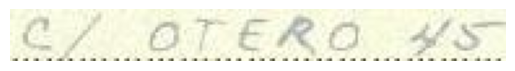

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



C/ OTERO 45


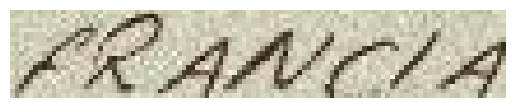

FRANCIA


In [37]:
import matplotlib.pyplot as plt

# Function to generate predictions on images
def generate_many():
    for i in range(10):
        image, pixel_values = retrieve_sample()
        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        plt.imshow(image)
        plt.axis("off")
        plt.show()
        print(generated_text)

generate_many()